# Gamma Paradigm Research - Interview Challenge (Kelly Criterion)
 - Ken Chiang (National Tsing Hua University - Quantitative Finance)
 - First Import Required Package : Numpy , Pandas , CVXPY , Matplotlib , self-built function

In [1]:
# basic
import numpy as np 
import pandas as pd
import datetime as dt 

# yahoo data source
import yfinance as yf 

# optimization package
import cvxpy as cp 
from scipy.spatial import ConvexHull

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Self Built Function 
from Utils.Convex_Hull import portfolio_convex_hull
from Utils.Portfolio_Summary import Backtest_Summay_DF, Portfolio_Beta , create_drawdowns , Underwater_Plot
from Utils.Kelly_Optimization import Kelly_Portfolio_Optimization 


# Download Price Data with Yahoo Finance

In [2]:
start_date = '2018-08-02'
end_date   = '2021-10-31'

# yfinance likes the tickers formatted as a list
ticks    = yf.Tickers(["XLE","XLF","XLK","XLV","XLI","XLY","XLC","XLP","XLU","XLB","XLRE"])
Stock_DF = ticks.history(start=start_date, end=end_date).Close
Stock_DF = Stock_DF.fillna(value=0)

bench_mark    = yf.Ticker("CAPE")
bench_mark_df = bench_mark.history(start=start_date, end=end_date)
bench_mark_df = bench_mark_df.fillna(value=0)

Returns_DF = Stock_DF.dropna().pct_change().dropna()
Stock_DF

[*********************100%***********************]  11 of 11 completed


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2018-08-01,55.302654,46.907429,63.610241,26.078333,71.394180,68.820595,48.592289,29.826426,47.165131,83.837997,106.798607
2018-08-02,54.937836,47.218464,63.258926,26.087658,71.300117,69.686142,49.086273,29.682989,47.398930,84.149017,107.531693
2018-08-03,55.461681,47.539219,62.932724,26.236946,71.365967,69.936180,49.662575,30.068485,47.929478,84.648552,107.898232
2018-08-06,55.442970,48.015480,63.166924,26.376900,71.469482,70.311264,49.708309,30.005728,47.965450,84.799377,108.621674
2018-08-07,55.630062,48.073803,63.635330,26.498196,71.977554,70.580536,49.406437,29.942972,47.893509,84.808792,109.123245
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,85.680000,80.730003,58.799999,40.570000,105.040001,158.929993,71.239998,47.830002,66.959999,131.830002,197.529999
2021-10-26,85.919998,80.010002,59.139999,40.599998,104.389999,159.380005,71.489998,48.049999,67.320000,132.479996,197.559998
2021-10-27,84.690002,79.790001,57.439999,39.930000,103.169998,159.240005,71.070000,47.700001,66.870003,131.429993,198.000000


# Equities Statistic Visualization : Price , Returns' Correlation Matrix , Equities Convex Hull 

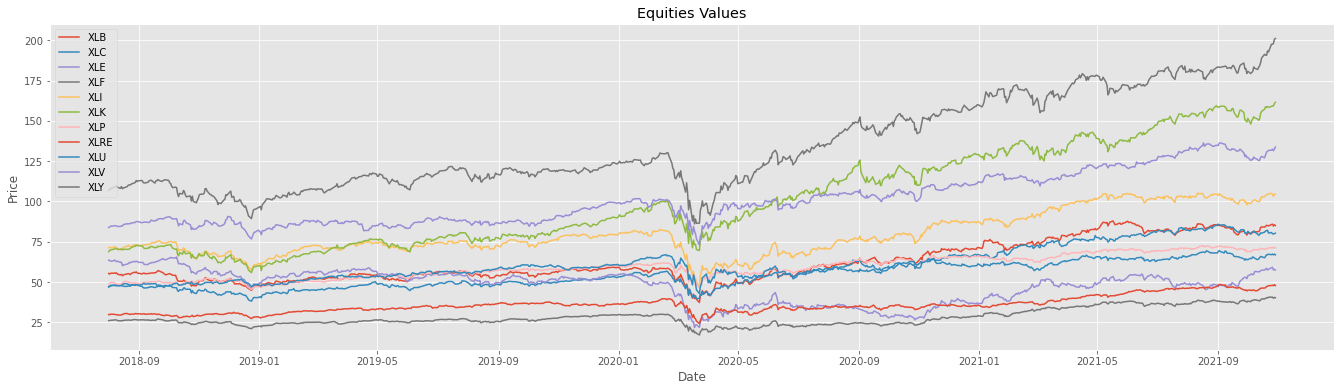

In [3]:
fig ,ax = plt.subplots(figsize=(23,6))
ax.set_title("Equities Values")
for i in range(Stock_DF.shape[1]):
    ax.plot(Stock_DF.index , Stock_DF[str(Stock_DF.columns[i])],label=str(Stock_DF.columns[i]))

ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.legend()

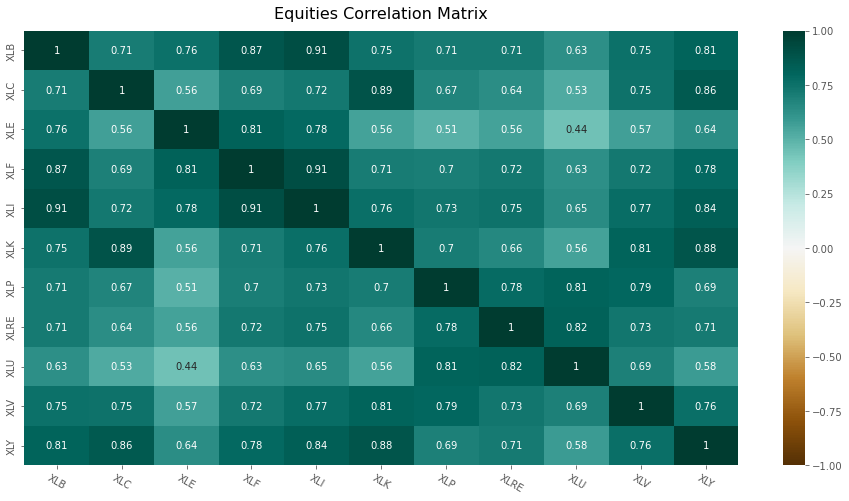

In [4]:
plt.figure(figsize=(16, 8))
corr = Returns_DF.corr()
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True , cmap='BrBG' )
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Equities Correlation Matrix', fontdict={'fontsize':16}, pad=12) ;
plt.xticks(rotation=-30)
plt.show()

          Equities Covex Hull
----------------------------------------
      Unbiased_Std  Expected_Returns
XLB       0.256559          0.165930
XLC       0.236599          0.193807
XLE       0.393510          0.046938
XLF       0.291130          0.176356
XLI       0.259202          0.151088
XLK       0.279566          0.302202
XLP       0.182135          0.134520
XLRE      0.252036          0.177643
XLU       0.242410          0.137077
XLV       0.205373          0.165206
XLY       0.235582          0.223103
----------------------------------------


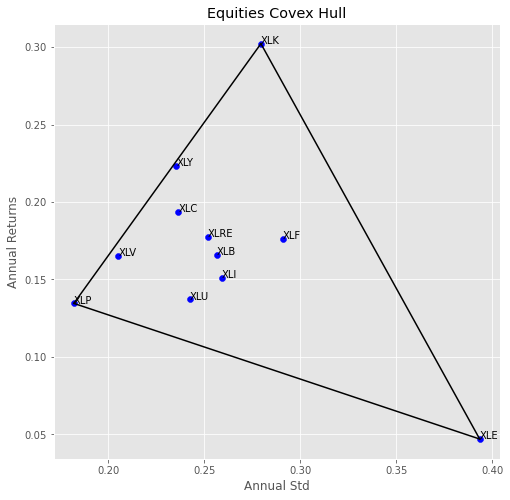

In [5]:
Expected_Return   = Stock_DF.pct_change().mean() * 252
Unbiased_Std      = Stock_DF.pct_change().std() * np.sqrt(252)

CovexHull_DF = pd.DataFrame({
    "Unbiased_Std" : Unbiased_Std ,
    "Expected_Returns" : Expected_Return ,
    })

portfolio_convex_hull(CovexHull_DF)

# BackTesting With Kelly's Portfolio Optimizatioin Problem

    - First Determine Some Parameters 
    - Rebalance Frequency               : Monthly Rebalance (22 dates)
    - Risk Free Rate                    : Using Current 10 years T-Bill : 0.00156

In [6]:
Rebalance_Count    = 0 
Rebalance_Date     = 22 
Initial_Investment = 100000
Risk_Free_Rate     = 0.00156

In [7]:
Portfolio_Reutrns   = pd.DataFrame(columns=['Daily Return'])
Equities_Weights_df = pd.DataFrame()
Portfolio_DF        = pd.DataFrame()

bench_mark_returns = []
benchmark_Values   = []
Portfolio_Values   = []
Portfolio_Index    = []

for i in range(Returns_DF.shape[0]):

    if Returns_DF[:i].shape[0] >= 252 : # First year for Initial Optimization Paramters' Data 

        Rebalance_Count+=1 

        if i == 252 :  # First Day Enter the Market 
            
            # (1.)BenchMark
            Benchmarkt_Unit = Initial_Investment / bench_mark_df.Close[i]
            # (2.) Portfolio
            # ---------------- Optimization Required's Data ------------------
            Cov_Matrix       = Returns_DF[:i-2].cov()  * 252
            Expected_Return  = np.array(Returns_DF[:i-2].mean() * 252).reshape(Cov_Matrix.shape[1],1)

            # ------------------ Performace Optimization ----------------------
            Model            = Kelly_Portfolio_Optimization(cov=Cov_Matrix , u=Expected_Return , risk_free_rate=Risk_Free_Rate  )
            Result,Params    = Model.Optimize()
            Result.solve()  
            Weights          = np.round(Params.value,decimals=5)
            Equities_Unit    = np.array([invest/Stock_DF.iloc[i,j] for j,invest in enumerate(Weights * Initial_Investment) ])

        if ( Rebalance_Count == Rebalance_Date ) :  # Rebalance Date

            # ---------------- Optimization Required's Data ------------------
            Cov_Matrix       = Returns_DF[:i-2].cov()  * 252
            Expected_Return  = np.array(Returns_DF[:i-2].mean() * 252).reshape(Cov_Matrix.shape[1],1)

            # ------------------ Performace Optimization ----------------------
            Model            = Kelly_Portfolio_Optimization(cov=Cov_Matrix , u=Expected_Return , risk_free_rate=Risk_Free_Rate  )
            Result,Params    = Model.Optimize()
            Result.solve()  
            Weights          = np.round(Params.value,decimals=5)

            Equities_Unit   = np.array([invest/Stock_DF.iloc[i,j] for j,invest in enumerate(Weights * Initial_Investment) ])
            Rebalance_Count = 0
        
        
        # Record the Data
        Date                     = Returns_DF.index[i]
        bench_mark_marekt_values = Benchmarkt_Unit * bench_mark_df['Close'][i]
        Portfolio_Market_Values  = Equities_Unit @ Stock_DF.iloc[i]
        Initial_Investment       = Portfolio_Market_Values

        # Append to Dataframe and list
        Portfolio_Index.append(Date)
        Portfolio_Values.append(Portfolio_Market_Values)
        benchmark_Values.append(bench_mark_marekt_values)
        Equities_Weights_df  =Equities_Weights_df .append(pd.Series(Weights,index=Stock_DF.columns,name=Stock_DF.index[i]))
            

# BackTesting Dataframe
Portfolio_DF['Portfolio Market Value']        = Portfolio_Values
Portfolio_DF['Bench Mark Market Value']       = benchmark_Values
Portfolio_DF['Portfolio Daily Return']        = Portfolio_DF['Portfolio Market Value'].pct_change()
Portfolio_DF['Bench Mark Daily Return']       = Portfolio_DF['Bench Mark Market Value'].pct_change()
Portfolio_DF['Portfolio Cumulative Return']   = Portfolio_DF['Portfolio Daily Return'].cumsum()
# Date Index
Portfolio_DF["Date"] = Portfolio_Index
Portfolio_DF.index   = Portfolio_DF['Date']
Portfolio_DF         = Portfolio_DF.drop(['Date'],axis=1)
Portfolio_DF = Portfolio_DF.dropna()
Portfolio_DF 

,Portfolio Market Value,Bench Mark Market Value,Portfolio Daily Return,Bench Mark Daily Return,Portfolio Cumulative Return
Date,,,,,
2019-08-06,98252.526182,97187.844511,-0.017475,-0.028122,-0.017475
2019-08-07,99524.868726,98147.203876,0.012950,0.009871,-0.004525
2019-08-08,99815.671511,99099.229972,0.002922,0.009700,-0.001603
2019-08-09,101005.326473,100710.363412,0.011919,0.016258,0.010315
2019-08-12,100976.439731,100102.526102,-0.000286,-0.006035,0.010029
...,...,...,...,...,...
2021-10-25,166026.695675,161625.779029,-0.003460,0.001816,0.600040
2021-10-26,166571.686873,162431.349241,0.003283,0.004984,0.603322
2021-10-27,167043.336630,162138.409539,0.002832,-0.001803,0.606154


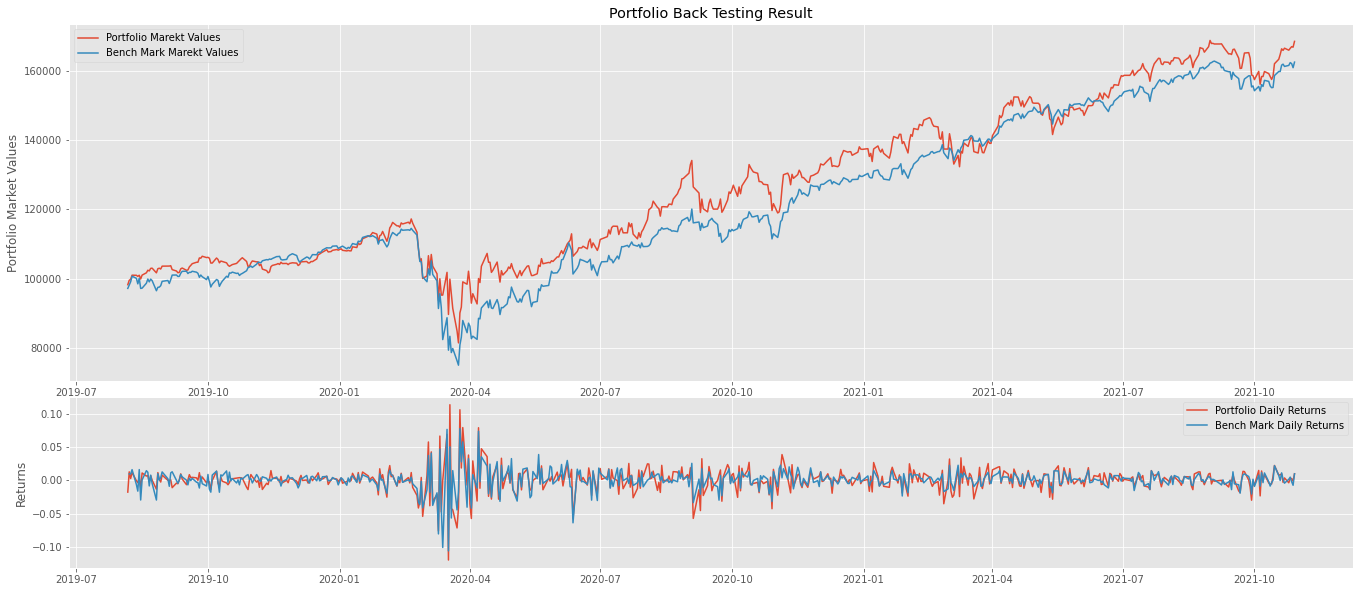

In [8]:
plt.subplots(figsize=(23,10))

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4,colspan=1)

ax1.set_title('Portfolio Back Testing Result')
ax1.plot(Portfolio_DF.index , Portfolio_DF['Portfolio Market Value']  ,label='Portfolio Marekt Values')
ax1.plot(Portfolio_DF.index , Portfolio_DF['Bench Mark Market Value']  ,label='Bench Mark Marekt Values')
ax1.set_ylabel('Portfolio Market Values')
ax1.legend()

ax2 = plt.subplot2grid((6,1),(4,0),rowspan=3,colspan=1)
ax2.plot(Portfolio_DF.index , Portfolio_DF['Portfolio Daily Return'],label='Portfolio Daily Returns')
ax2.plot(Portfolio_DF.index , Portfolio_DF['Bench Mark Market Value'].pct_change(),label='Bench Mark Daily Returns')
ax2.set_ylabel('Returns')
ax2.legend()

- Just From the above Figure , we can see that Kelly Portfolio have higher real earn , and smaller drawdown compare with the benchmark

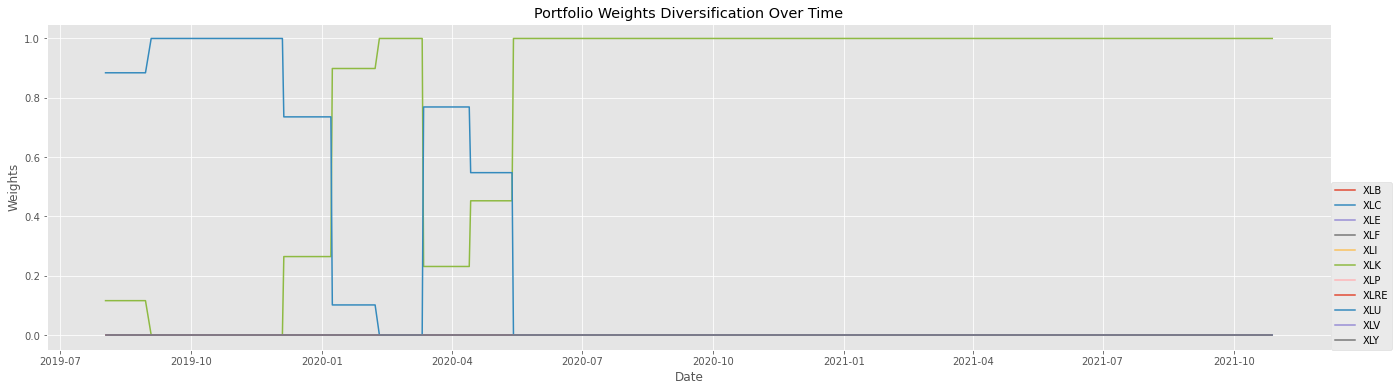

In [9]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Portfolio Weights Diversification Over Time')
for i in range(Equities_Weights_df.shape[1]):
    ax.plot(Equities_Weights_df.index , Equities_Weights_df[str(Equities_Weights_df.columns[i])],label=str(Equities_Weights_df.columns[i]))

ax.set_ylabel('Weights')
ax.set_xlabel('Date')
ax.legend(loc=[1,0])

- portfolio optimization result mainly focus on [ XLU (utility) , XLK (technology) ]

# BackTesting Result - Risk and Performance Metrics (Portfolio Raio/Beta/Drawdown)

In [10]:
Backtest_Summay_DF(start_date,end_date,Portfolio_DF['Portfolio Daily Return'],Portfolio_DF['Bench Mark Daily Return'])

,Backtest
Start Date,2018-08-02
End Date,2021-10-31
-,-
Annual Return,0.274445
Annual Volitiliy,0.287908
Cumulative Return,0.615323
Sharpe Ratio,0.953239
Calmar Ratio,0.833224
Omega Ratio,1.02509
Sortino Ratio,0.109606


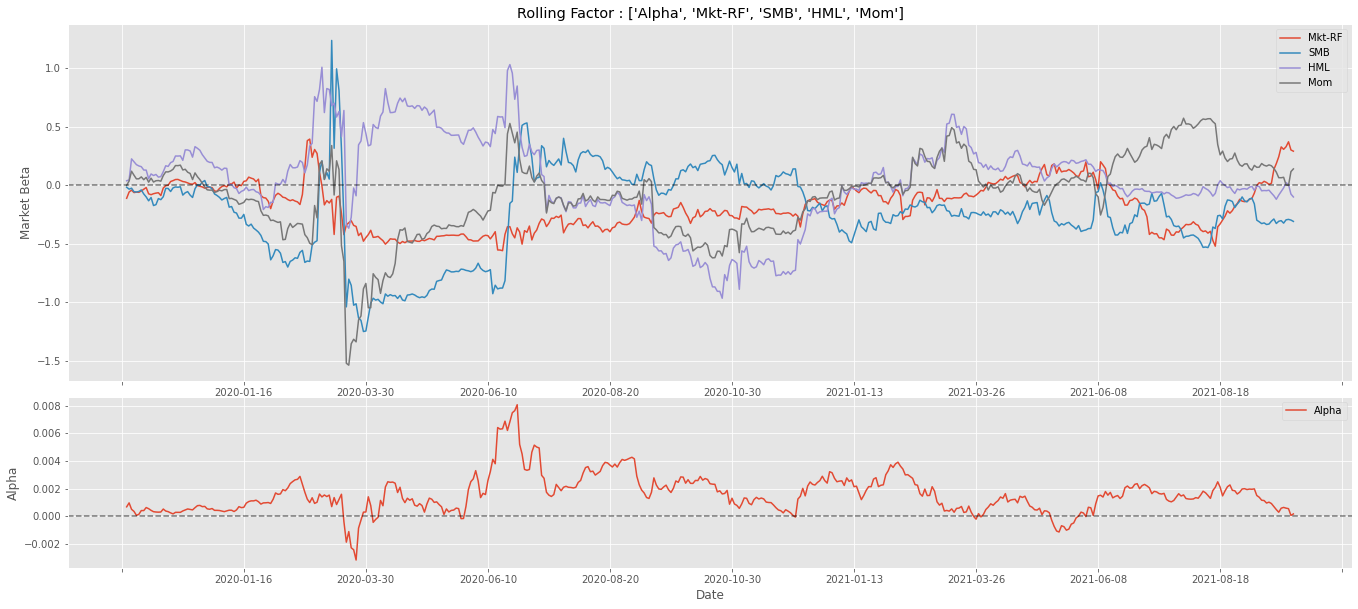

In [11]:
Portfolio_Beta(Portfolio_DF,Windows=(22*3))

 - The Above Alpha might state that , excpet for the drawdown cause by the COVID-19 , the other time period we have constant return (Alpha) from the portfolio

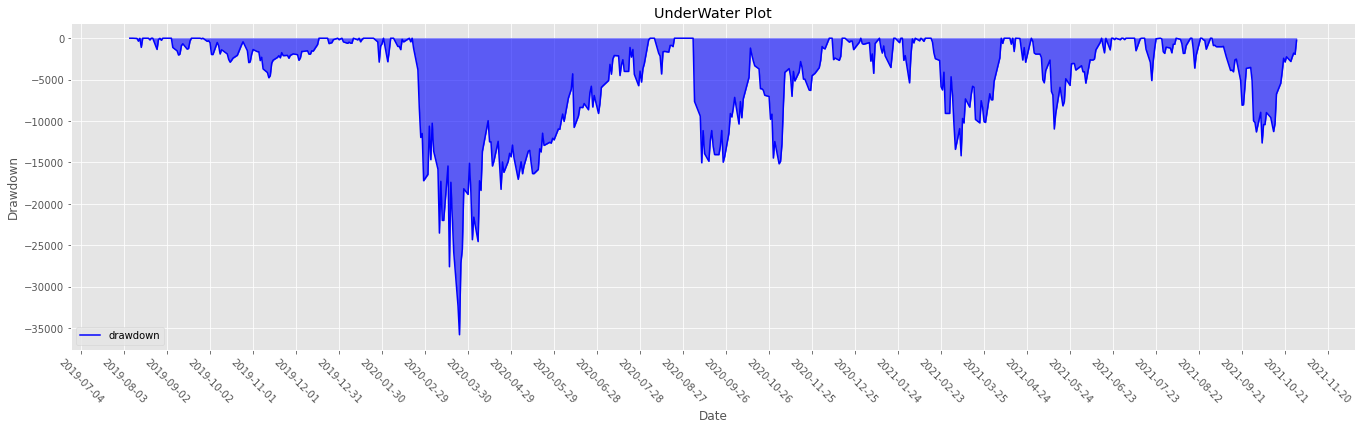

,Date,Equity Values,Drawdown Value,Drawdown Percentage,Drawdown duration,Peak Date,Peak Equity Values,Recovery duraton,Recovery Date
0,2020-03-24,81445.810661,35812.803164,30.541725,23.0,2020-02-20,117258.613825,92.0,2020-06-24
1,2020-11-02,118989.987168,15170.752281,11.307893,41.0,2020-09-03,134160.739449,24.0,2020-11-26
2,2021-03-09,132344.689091,14194.321755,9.686377,15.0,2021-02-16,146539.010846,19.0,2021-03-28
3,2021-10-05,156191.723399,12650.963050,7.492752,24.0,2021-08-31,168842.686449,24.0,2021-10-29
4,2021-05-13,141653.634192,10966.207450,7.185309,12.0,2021-04-27,152619.841641,22.0,2021-06-04


In [12]:
drawdown_df ,top_5_drawdown = create_drawdowns(Portfolio_DF['Portfolio Market Value'])
Underwater_Plot(drawdown_df)
top_5_drawdown